<a href="https://colab.research.google.com/github/HiuNgaiChan/3dSinGAN/blob/master/SPWGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

learningRate = 0.00005
batch_size = 1000
single_data_size = 3
latent_size = 200

dataCSV = pd.read_csv('noNorm1000.csv')
dataTensor = torch.tensor(dataCSV.values).to(torch.float32)
dataset = torch.utils.data.DataLoader(dataTensor, batch_size=batch_size, shuffle=True)


class DNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.net = nn.Sequential(
          nn.Linear(single_data_size, 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Linear(128, 1)
      )


    def forward(self, x):

      return self.net(x)

class GNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.net = nn.Sequential(
          nn.Linear(latent_size, 256),
          nn.ReLU(),
          nn.Linear(256, 512),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256,single_data_size),
          nn.Tanh()
      )


    def forward(self, x):

      return self.net(x)

In [11]:
d = DNet()
g = GNet()

In [12]:
Epoch = 5000

optimizerD = optim.RMSprop(d.parameters(), lr=0.00005)
optimizerG = optim.RMSprop(g.parameters(), lr=0.00005)

dlossList = []
glossList = []

print('start training...')


for epoch in range(Epoch):
  for batch in dataset:
    d.zero_grad()
    d_real_loss = d(batch.view(batch_size,3))

    Z = torch.rand(batch_size,200)
    d_fake_loss = d(g(Z))

    d_loss = -torch.mean(d_real_loss) + torch.mean(d_fake_loss)

    d_loss.backward()
    optimizerD.step()
    for p in d.parameters():
      p.data.clamp_(-0.01, 0.01)

    Z = torch.rand(batch_size,200)
    g.zero_grad()
    gd_output = d(g(Z))


    g_loss = -torch.mean(gd_output)
    g_loss.backward()
    optimizerG.step()
  if epoch%10 == 0:
    dlossList.append(d_loss.item())
    glossList.append(g_loss.item())    

  if epoch%100 == 0:
    print(epoch)
    print('d_loss: ' + str(d_loss) +' g_loss: ' + str(g_loss))
print("finish training")

start training...
0
d_loss: tensor(0.0096, grad_fn=<AddBackward0>) g_loss: tensor(0.0110, grad_fn=<NegBackward>)
finish training


In [10]:
print(len(dlossList))

4


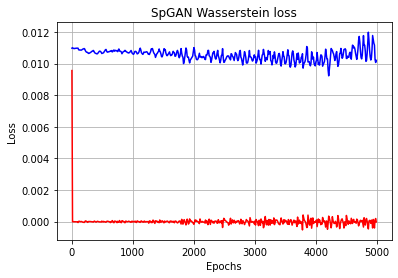

In [15]:
xis = np.arange(0,Epoch,10)
plt.plot(xis,dlossList,'r-', xis, glossList, 'b-')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('SpGAN Wasserstein loss')
plt.grid(True)
plt.savefig("spganWLoss.png")
plt.show()

In [17]:
import csv
import torch

for j in range(9):
  with open("swCube" + str(j) + ".csv", "w", newline="") as csvfile:
    xyzWriter = csv.writer(csvfile, delimiter=",")
    for i in range(1000):
      with torch.no_grad():
        Z = torch.rand(200)
        line = g(Z).tolist()
      xyzWriter.writerow(line)
